### Import pandas and read in the csv file and set it to a dataframe called baskets

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### put the utility functions together

In [2]:
def add_date_cols(baskets):
    baskets['datetime'] = pd.to_datetime(baskets['placed_at'])
    baskets['year'] = baskets["datetime"].dt.year
    baskets['month'] = baskets["datetime"].dt.month
    baskets['date'] = baskets["datetime"].dt.date
    baskets['day'] = baskets["datetime"].dt.day
    baskets['hour'] = baskets["datetime"].dt.hour
    baskets['weekday'] = baskets["datetime"].dt.weekday
    baskets['year_month'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%m"))
    baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
    baskets['year_week'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
    baskets['week_num'] = baskets["datetime"].apply(lambda t: int(t.strftime("%W"))) 
    baskets['iso_week_num'] = baskets["datetime"].dt.isocalendar().week # this returns week number 52 for Jan 1, 2021, not 0 which is what we want
    baskets['cum_week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
    return baskets
def get_merchant_attributes(baskets):
    merchant_attributes = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat','nunique'), 
        num_sub_cats = ('sub_cat','nunique'),
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    return merchant_attributes

In [3]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)
merchant_attributes = get_merchant_attributes(baskets)

<AxesSubplot:>

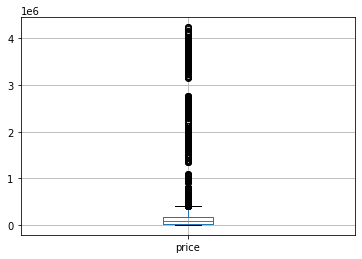

In [4]:
baskets.boxplot(column = 'price')

 - we can see that prices of SKUs probably have outliers, but outliers should be considered within context
 - perhaps we need to inspect at different resolutions, such as by category, by date, by transaction?
 - question: where should we cut to separate outliers from the regular items?

 - looking at density plot

<AxesSubplot:ylabel='Density'>

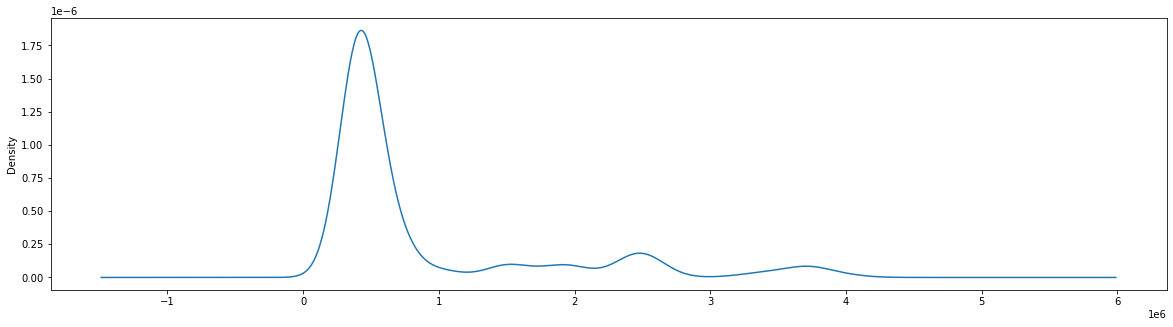

In [5]:
baskets.price.sort_values(ascending = False).reset_index(drop=True)[10:10000].plot.density(figsize=(20,5))

 - looking at histogram

<AxesSubplot:>

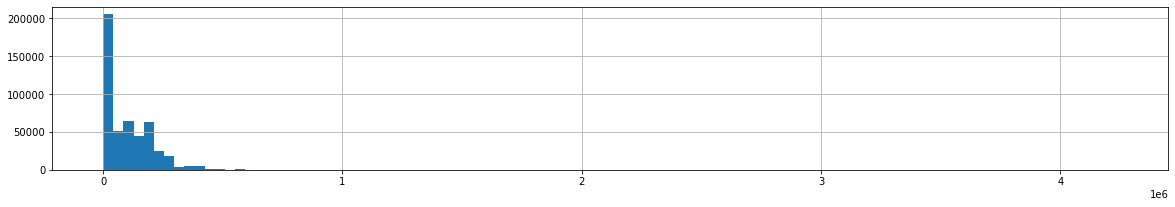

In [6]:
plt.figure(figsize=(20,3)) 
baskets.price.sort_values(ascending = False).reset_index(drop=True).hist(bins=100)

 - looking at different ranges of the price

<AxesSubplot:>

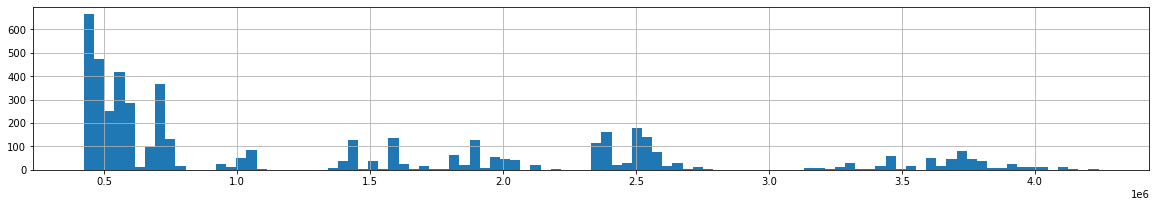

In [7]:
plt.figure(figsize=(20,3)) 
baskets.price.sort_values(ascending = False).reset_index(drop=True)[:5000].hist(bins=100)

<AxesSubplot:>

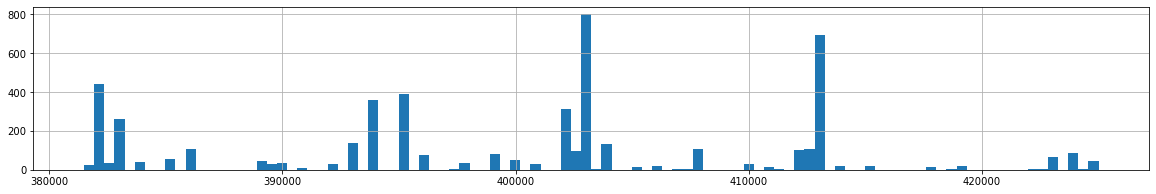

In [8]:
plt.figure(figsize=(20,3)) 
baskets.price.sort_values(ascending = False).reset_index(drop=True)[5000:10000].hist(bins=100)

<AxesSubplot:>

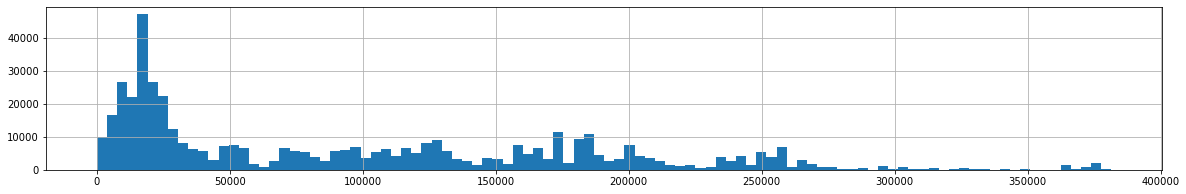

In [9]:
plt.figure(figsize=(20,3)) 
baskets.price.sort_values(ascending = False).reset_index(drop=True)[10000:].hist(bins=100)

 - all the above charts may not be very intuitive for deriving insights
 - perhaps look by category, at boxplot for each category
 - using Seaborn package : https://seaborn.pydata.org/

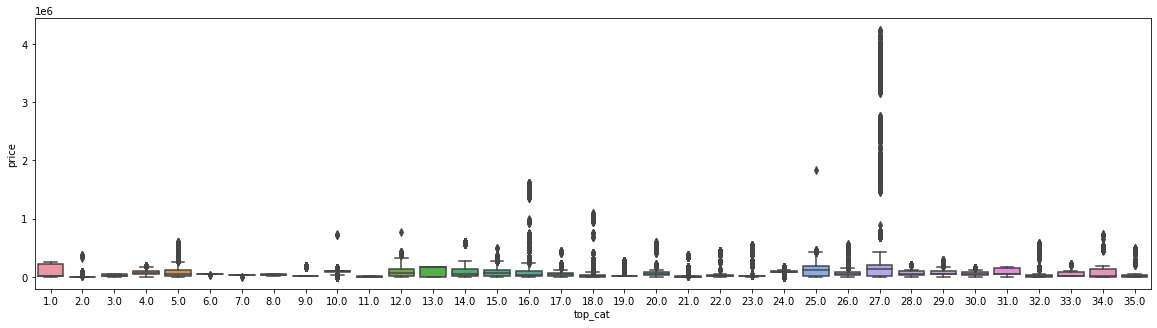

In [10]:
import seaborn as sns
plt.figure(figsize=(20,5)) 
ax = sns.boxplot(data=baskets, x="top_cat", y="price")

In [11]:
baskets.groupby(by='top_cat')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
top_cat,,,,,,,,
1.0,1039.0,97580.697252,95276.555805,309.027778,24000.0,25500.0,226000.0,254500.0
2.0,275.0,21320.363636,51195.677494,7000.000000,7750.0,8500.0,8500.0,370000.0
3.0,556.0,29576.258993,20049.544338,2500.000000,11000.0,11000.0,51000.0,51000.0
4.0,1677.0,82935.773206,39711.550135,1958.333333,56000.0,66000.0,107000.0,195000.0
5.0,28773.0,84103.356815,88434.216902,441.666667,15000.0,51000.0,115000.0,605000.0
6.0,29.0,49551.724138,4602.687157,37000.000000,48000.0,52000.0,52000.0,52000.0
7.0,23.0,28565.217391,8066.913835,3000.000000,31000.0,31000.0,31000.0,31000.0
8.0,166.0,42216.867470,10901.679818,17000.000000,37000.0,40000.0,52000.0,55000.0
9.0,694.0,28994.596542,51009.261889,10937.500000,11500.0,11500.0,12000.0,182000.0


<AxesSubplot:>

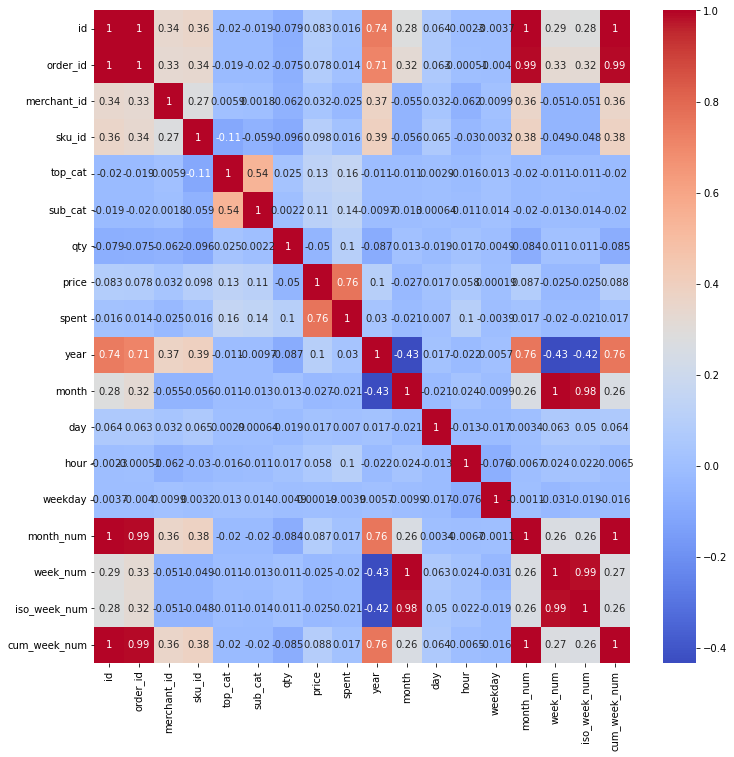

In [12]:
#Correlation plot
plt.figure(figsize=(12,12)) 
sns.heatmap(baskets.corr(),annot=True, cmap='coolwarm')

 - but does this above make any sense?
 - order_id and line_id are correlated? 
 - sub cat and top are correlated?

<AxesSubplot:>

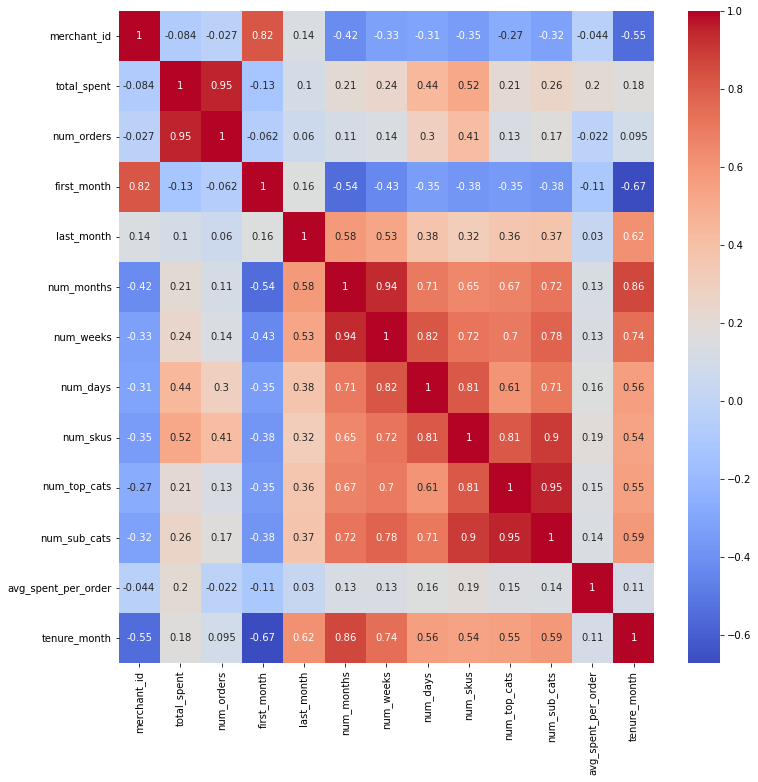

In [13]:
#Correlation plot
plt.figure(figsize=(12,12)) 
sns.heatmap(merchant_attributes.corr(),annot=True, cmap='coolwarm')


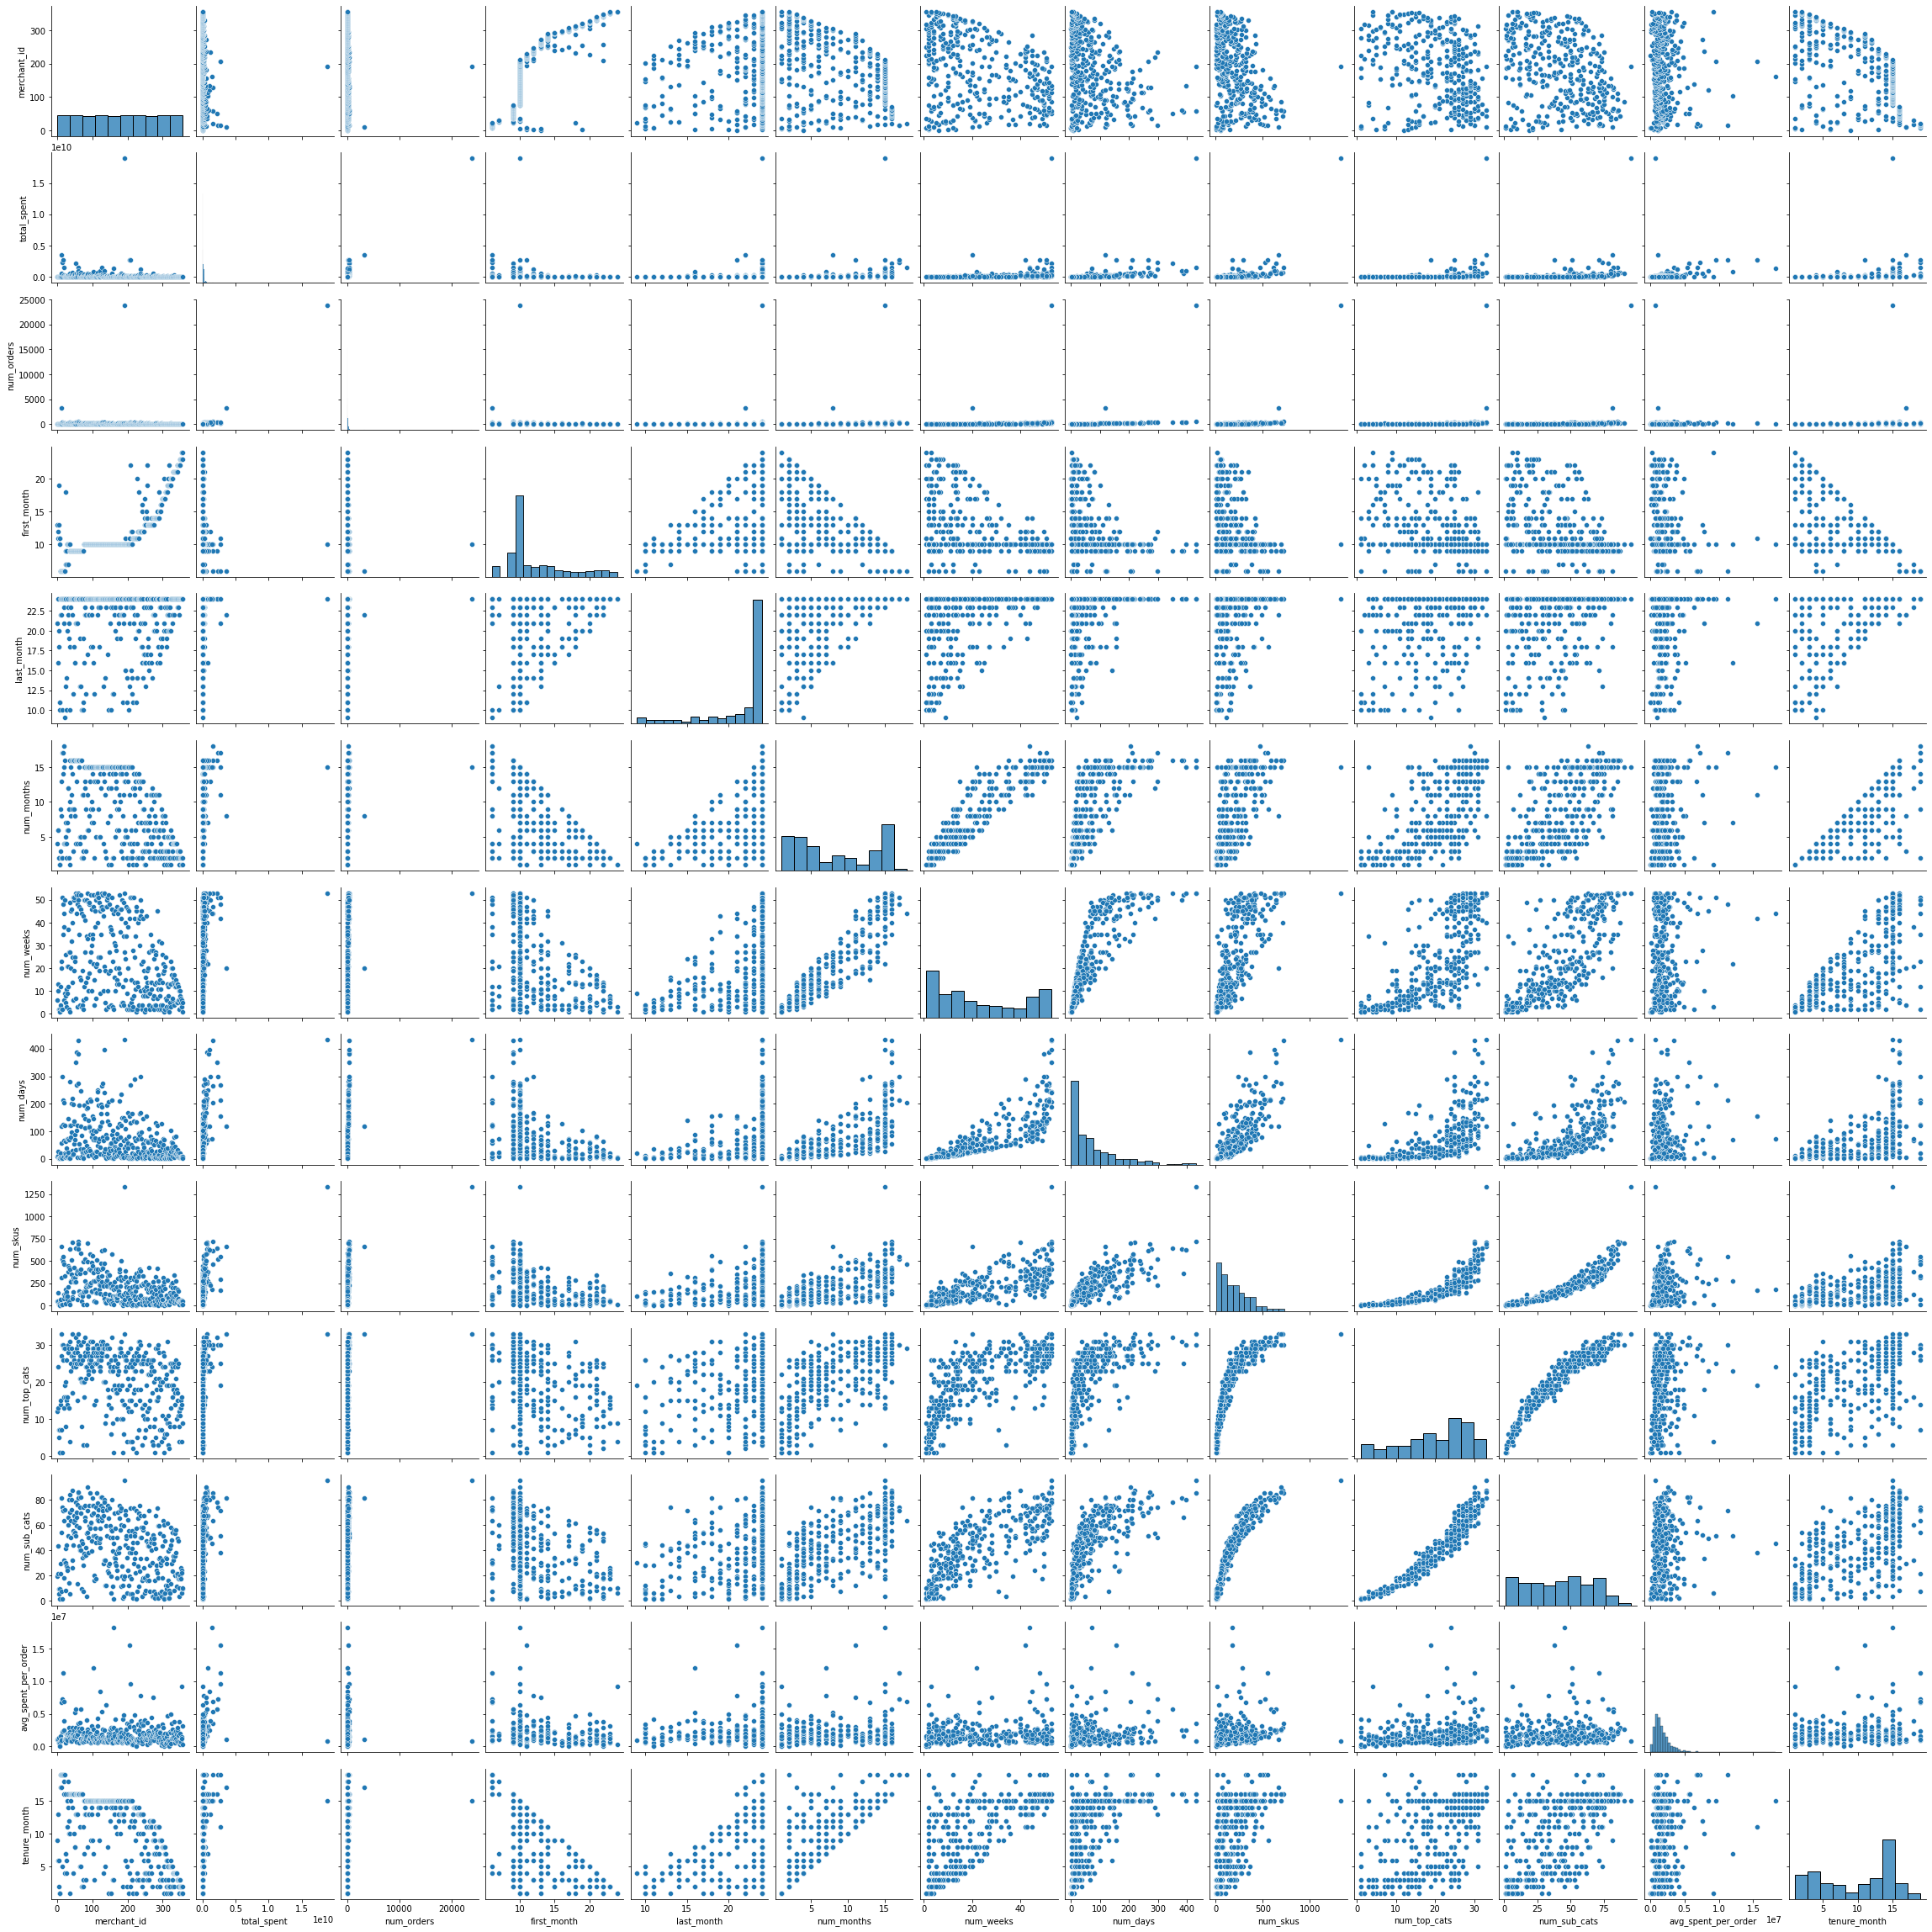

In [14]:
sns.pairplot(merchant_attributes)

In [15]:
merchant_attributes.columns

Index(['merchant_id', 'total_spent', 'num_orders', 'first_month', 'last_month',
       'num_months', 'num_weeks', 'num_days', 'num_skus', 'num_top_cats',
       'num_sub_cats', 'avg_spent_per_order', 'tenure_month'],
      dtype='object')

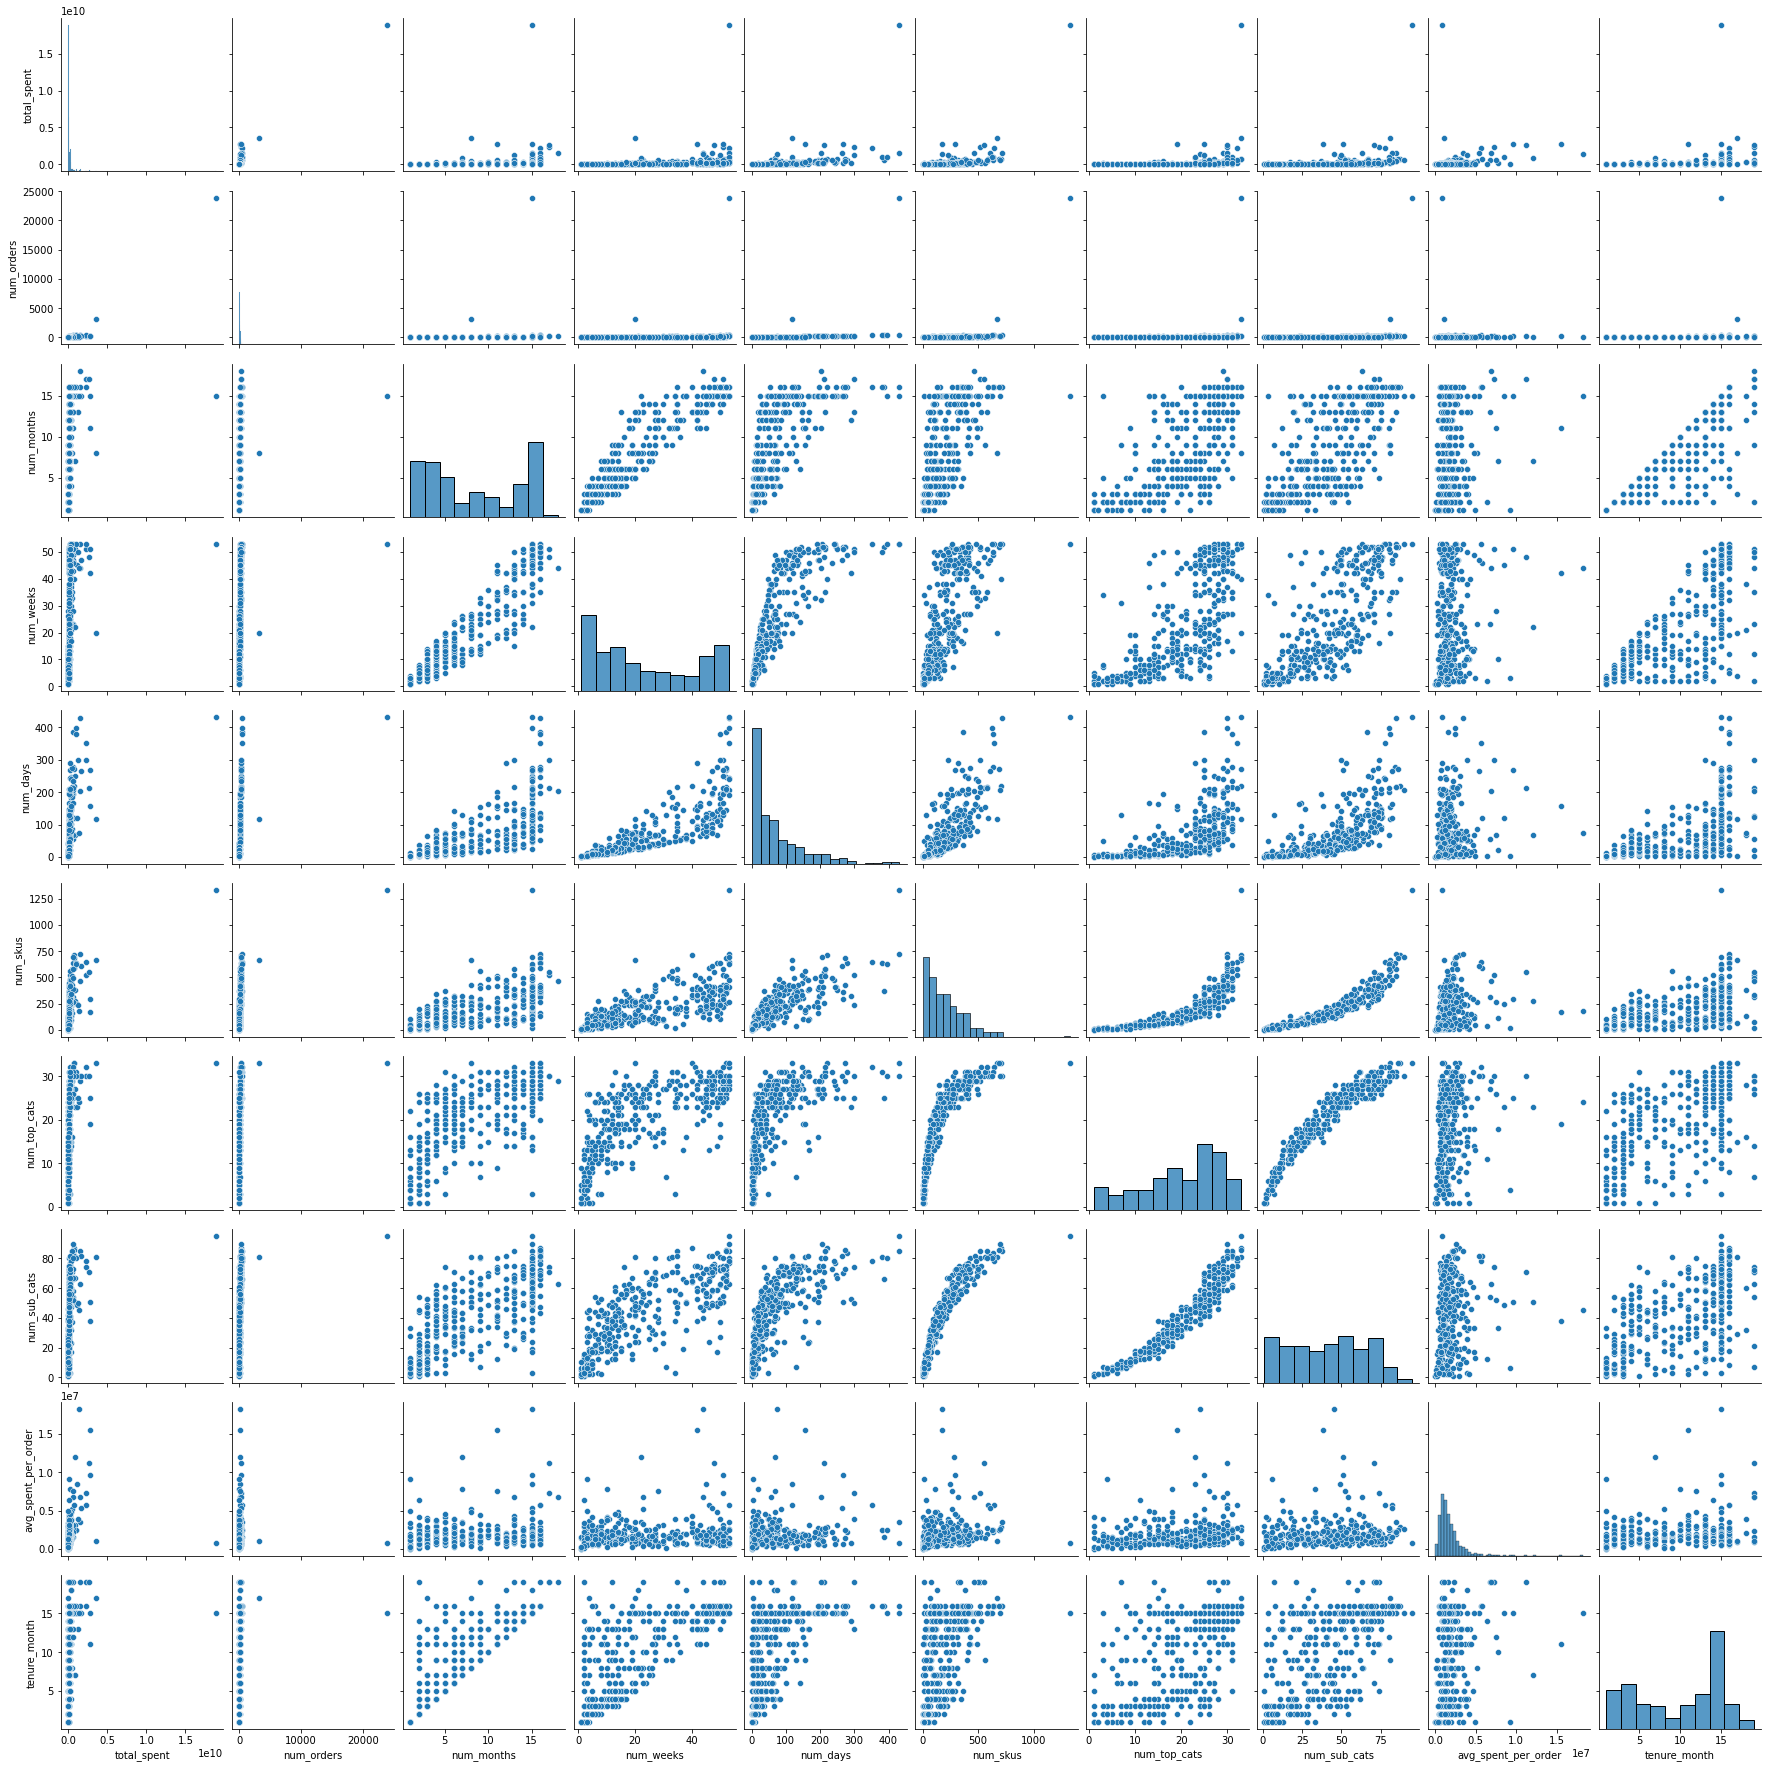

In [16]:
sns.pairplot(merchant_attributes[merchant_attributes.columns[[1,2,5,6,7,8,9,10,11,12]]])

### what should we do about the rows/columns that have null values

In [17]:
baskets.isnull().sum()

id                0
order_id          0
placed_at         0
merchant_id       0
sku_id            0
top_cat         988
sub_cat         988
qty               0
price             0
spent             0
datetime          0
year              0
month             0
date              0
day               0
hour              0
weekday           0
year_month        0
month_num         0
year_week         0
week_num          0
iso_week_num      0
cum_week_num      0
dtype: int64

In [18]:
#Removing these null values
baskets.dropna(inplace=True) # without inplace, it will be alter the data frame itsefle

In [19]:
baskets.isnull().sum()

id              0
order_id        0
placed_at       0
merchant_id     0
sku_id          0
top_cat         0
sub_cat         0
qty             0
price           0
spent           0
datetime        0
year            0
month           0
date            0
day             0
hour            0
weekday         0
year_month      0
month_num       0
year_week       0
week_num        0
iso_week_num    0
cum_week_num    0
dtype: int64

<AxesSubplot:ylabel='Frequency'>

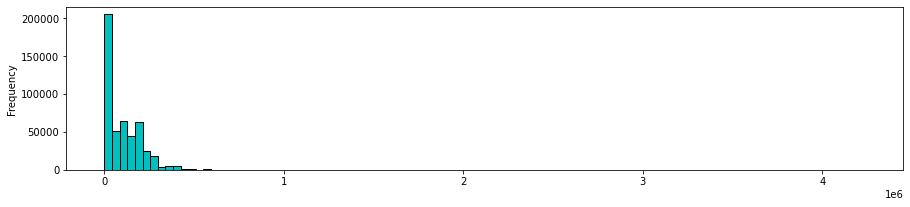

In [20]:
plt.figure(figsize=(15,3)) 
baskets.price.sort_values(ascending = False).reset_index(drop=True).plot.hist(bins=100,color = "c",edgecolor = 'k')

Text(124350.55360116884, 193589.86500000002, 'Mean: 113045.96')

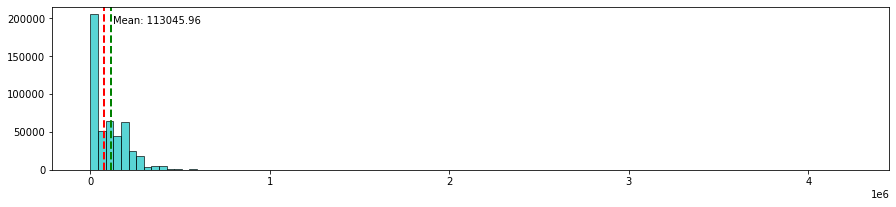

In [21]:
plt.figure(figsize=(15,3)) 
result = plt.hist(baskets.price, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(baskets.price.mean(), color='g', linestyle='dashed', linewidth=2)
plt.axvline(baskets.price.median(), color='r', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(baskets.price.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(baskets.price.mean()))

In [22]:
baskets.price.median()

76500.0

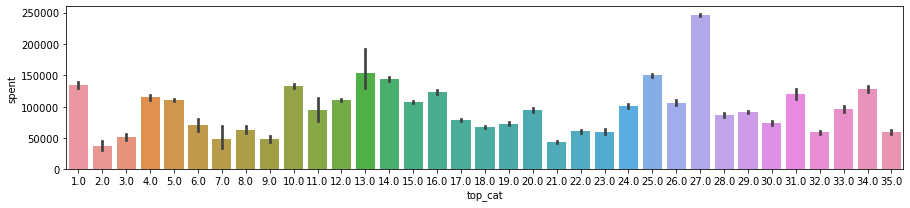

In [23]:
plt.figure(figsize=(15,3)) 
ax = sns.barplot(x="top_cat", y="spent", data=baskets)

 - interpretation of the above plot: bar height = estmate of central tendency, error = indication of uncertainty

 - doing pivot table

In [24]:
baskets.pivot_table(values='price', index=["top_cat"], columns="weekday", aggfunc=np.mean).reset_index()

weekday,top_cat,0,1,2,3,4,5,6
0,1.0,92942.576477,98863.410747,89879.478145,91989.152299,98314.764685,98710.439068,110497.042336
1,2.0,20221.153846,14705.882353,15277.777778,13515.625000,19371.052632,38337.500000,31134.615385
2,3.0,29390.526316,28478.787879,32837.735849,34122.388060,28357.534247,30292.380952,25724.742268
3,4.0,82116.720085,86528.455285,81245.967742,80201.357466,79331.967213,83168.576389,90276.606426
4,5.0,88751.560896,88866.837633,85789.093343,79546.739441,80168.486884,83415.037750,80166.305740
5,6.0,50500.000000,51000.000000,48250.000000,50000.000000,47800.000000,52000.000000,45666.666667
6,7.0,31000.000000,21666.666667,31000.000000,24000.000000,31000.000000,31000.000000,31000.000000
7,8.0,41760.000000,36166.666667,41166.666667,43000.000000,47282.608696,41500.000000,41982.758621
8,9.0,32113.821138,27166.447368,27231.958763,31963.855422,26440.563725,33662.280702,22031.250000
9,10.0,87422.285714,86647.981711,85398.407332,85675.155104,85263.339921,86675.939681,86932.161584


In [32]:
baskets.drop_duplicates(["placed_at"]).order_id.nunique()

53410

In [29]:
baskets.order_id.nunique()

53414